# Tuning Machine Learning models in Spark

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

## ML Pipelines in Spark

ML model training and tuning often represents running the same steps once and again. Often, we run the same steps with small variations in order to evaluate combinations of parameters. 

In order to make this use case a lot easier, Spark provides the [Pipeline](https://spark.apache.org/docs/2.3.0/ml-pipeline.html) abstraction.

A Pipeline represents a series of steps in the processing of a dataset. Each step is a Transformer or an Estimator. The whole Pipeline is an Estimator, so we can .fit the whole pipeline in one step. When we do that, the steps'  .fit and .transform methods will be called in turn.

### Training time

![pipelineestimator](https://spark.apache.org/docs/2.3.0/img/ml-Pipeline.png)

### Testing time


![PipelineModel](https://spark.apache.org/docs/2.3.0/img/ml-PipelineModel.png)

# Basic Example

In [1]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

# Prepare training data from a list of (label, features) tuples.
training = spark.createDataFrame([
    (Vectors.dense([0.0, 1.1, 0.1]),1.0),
    (Vectors.dense([2.0, 1.0, -1.0]),0.0),
    (Vectors.dense([2.0, 1.3, 1.0]),0.0),
    (Vectors.dense([0.0, 1.2, -0.5]),1.0)], ["features","label"])

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01)
# Print out the parameters, documentation, and any default values.
print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

# Learn a LogisticRegression model. This uses the parameters stored in lr.
model1 = lr.fit(training)

# Since model1 is a Model (i.e., a transformer produced by an Estimator),
# we can view the parameters it used during fit().
# This prints the parameter (name: value) pairs, where names are unique IDs for this
# LogisticRegression instance.
print("Model 1 was fit using parameters: ")
print(model1.extractParamMap())

# We may alternatively specify parameters using a Python dictionary as a paramMap
paramMap = {lr.maxIter: 20}
paramMap[lr.maxIter] = 30  # Specify 1 Param, overwriting the original maxIter.
paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55})  # Specify multiple Params.

# You can combine paramMaps, which are python dictionaries.
paramMap2 = {lr.probabilityCol: "myProbability"}  # Change output column name
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap2)

# Now learn a new model using the paramMapCombined parameters.
# paramMapCombined overrides all parameters set earlier via lr.set* methods.
model2 = lr.fit(training, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(model2.extractParamMap())

# Prepare test data
test = spark.createDataFrame([
    (1.0, Vectors.dense([-1.0, 1.5, 1.3])),
    (0.0, Vectors.dense([3.0, 2.0, -0.1])),
    (1.0, Vectors.dense([0.0, 2.2, -1.5]))], ["label", "features"])

# Make predictions on test data using the Transformer.transform() method.
# LogisticRegression.transform will only use the 'features' column.
# Note that model2.transform() outputs a "myProbability" column instead of the usual
# 'probability' column since we renamed the lr.probabilityCol parameter previously.
prediction = model2.transform(test)
result = prediction.select("features", "label", "myProbability", "prediction") \
    .collect()

for row in result:
    print("features=%s, label=%s -> prob=%s, prediction=%s"
          % (row.features, row.label, row.myProbability, row.prediction))

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bou

In [2]:
LogisticRegression?

## Pipeline example

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.15964077387874745,0.8403592261212527], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476744,0.16216743145232562], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976037,0.9307336686702395], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444218,0.01784246665557808], prediction=0.000000


## Example: predicting flight delays

We'll be using the same [Transtats'](https://www.transtats.bts.gov/) OTP performance data] from way back when. Remember it?

It's a table that contains all domestic departures by US air air carriers that represent at least one percent of domestic scheduled passenger revenues, with data on each individual departure including [Tail Number](https://en.wikipedia.org/wiki/Tail_number), departure delay, origin, destination and carrier.


### Load the data

Opening .zip files in Spark is a bit of a pain. For now, let's just decompress the file we want to read. When we are ready to expand the processing to the cluster, we will need to do [this](https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark).

In [2]:
path = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2019_2.zip'
!unzip -o {path}

Archive:  On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2019_2.zip
  inflating: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv  
  inflating: readme.html             


In [4]:
!ls

 01-first_steps_with_distributed_systems-MapReduce.inclass.ipynb
 02-SparkSQL-DataFrames.inclass.ipynb
 03-porting-to-spark.inclass.ipynb
 04-working_on_cluster.ipynb
 05-ML_in_Spark.empty.ipynb
 06-intro_to_pandas_practical.html
 06-intro_to_pandas_practical.ipynb
 data
 derby.log
 holi
 metastore_db
 mysparkjob.py
 On_Time_On_Time_Performance_2015_8.csv
'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2016_12.csv.gz'
'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_1.csv'
 On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2019_1.zip
'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv'
 On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2019_2.zip
 out.csv
 out.json
 __pycache__
 readme.html
 spark-warehouse
 temp


In [7]:
file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_2.csv'
df = spark.read.csv(file, header=True, inferSchema=True)
df

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: timestamp, Reporting_Airline: string, DOT_ID_Reporting_Airline: int, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, Cancellati

Our data has been read in with all fields typed as strings. Let's use the inferSchema argument to .read.csv:

In [106]:
df2 = df.select('FlightDate', 'DayOfWeek', 'Year', 'Month', 'DayofMonth', 'DayOfWeek',
                 df['Reporting_Airline'].alias('Carrier'), 
                 df['Tail_Number'].alias('TailNum'), 
                 df['Flight_Number_Reporting_Airline'].alias('FlightNum'), 
                 'Origin', 'OriginCityName', 'OriginStateName', 
                 'Dest', 'DestCityName', 'DestStateName',
                 'DepTime', 'DepDelay', 'AirTime', 'Distance')

df2

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double]

### Drop nas

There are only a few departures for which any of the columns of interest contains null values. The most expedient way to handle them is to just drop them, since they won't make much of a difference.

In [17]:
df2.select(df2['DepDelay'].isNull())

DataFrame[(DepDelay IS NULL): boolean]

In [19]:
from pyspark.sql import functions, types

df2.select(df2['DepDelay'].isNull().cast(types.IntegerType())).show(5)

+-------------------------------+
|CAST((DepDelay IS NULL) AS INT)|
+-------------------------------+
|                              0|
|                              0|
|                              0|
|                              0|
|                              0|
+-------------------------------+
only showing top 5 rows



In [20]:
df2.select(functions.sum(df2['DepDelay']\
                           .isNull()\
                           .cast(types.IntegerType()))).show(5)

+------------------------------------+
|sum(CAST((DepDelay IS NULL) AS INT))|
+------------------------------------+
|                               14827|
+------------------------------------+



NA-related functions are grouped in a .na attribute of DataFrames.

In [21]:
df2.columns

['FlightDate',
 'DayOfWeek',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName',
 'DepTime',
 'DepDelay',
 'AirTime',
 'Distance']

In [22]:
df2['DepDelay'].isNull().cast(types.IntegerType())

Column<b'CAST((DepDelay IS NULL) AS INT)'>

In [28]:
null_counts = [functions.sum(df2[column].isNull().cast(types.IntegerType()) )
                    for column 
                    in df2.columns]
null_counts

[Column<b'sum(CAST((FlightDate IS NULL) AS INT))'>,
 Column<b'sum(CAST((DayOfWeek IS NULL) AS INT))'>,
 Column<b'sum(CAST((Carrier IS NULL) AS INT))'>,
 Column<b'sum(CAST((TailNum IS NULL) AS INT))'>,
 Column<b'sum(CAST((FlightNum IS NULL) AS INT))'>,
 Column<b'sum(CAST((Origin IS NULL) AS INT))'>,
 Column<b'sum(CAST((OriginCityName IS NULL) AS INT))'>,
 Column<b'sum(CAST((OriginStateName IS NULL) AS INT))'>,
 Column<b'sum(CAST((Dest IS NULL) AS INT))'>,
 Column<b'sum(CAST((DestCityName IS NULL) AS INT))'>,
 Column<b'sum(CAST((DestStateName IS NULL) AS INT))'>,
 Column<b'sum(CAST((DepTime IS NULL) AS INT))'>,
 Column<b'sum(CAST((DepDelay IS NULL) AS INT))'>,
 Column<b'sum(CAST((AirTime IS NULL) AS INT))'>,
 Column<b'sum(CAST((Distance IS NULL) AS INT))'>]

In [29]:
df2.select(null_counts).show()

+--------------------------------------+-------------------------------------+-----------------------------------+-----------------------------------+-------------------------------------+----------------------------------+------------------------------------------+-------------------------------------------+--------------------------------+----------------------------------------+-----------------------------------------+-----------------------------------+------------------------------------+-----------------------------------+------------------------------------+
|sum(CAST((FlightDate IS NULL) AS INT))|sum(CAST((DayOfWeek IS NULL) AS INT))|sum(CAST((Carrier IS NULL) AS INT))|sum(CAST((TailNum IS NULL) AS INT))|sum(CAST((FlightNum IS NULL) AS INT))|sum(CAST((Origin IS NULL) AS INT))|sum(CAST((OriginCityName IS NULL) AS INT))|sum(CAST((OriginStateName IS NULL) AS INT))|sum(CAST((Dest IS NULL) AS INT))|sum(CAST((DestCityName IS NULL) AS INT))|sum(CAST((DestStateName IS NULL) AS INT))|s

In [31]:
help(df2.na)

Help on DataFrameNaFunctions in module pyspark.sql.dataframe object:

class DataFrameNaFunctions(builtins.object)
 |  Functionality for working with missing data in :class:`DataFrame`.
 |  
 |  .. versionadded:: 1.4
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  drop(self, how='any', thresh=None, subset=None)
 |      Returns a new :class:`DataFrame` omitting rows with null values.
 |      :func:`DataFrame.dropna` and :func:`DataFrameNaFunctions.drop` are aliases of each other.
 |      
 |      :param how: 'any' or 'all'.
 |          If 'any', drop a row if it contains any nulls.
 |          If 'all', drop a row only if all its values are null.
 |      :param thresh: int, default None
 |          If specified, drop rows that have less than `thresh` non-null values.
 |          This overwrites the `how` parameter.
 |      :param subset: optional list of column names to consider.
 |      
 |      >

In [107]:
df3 = df2.na.drop()

## Feature extraction and generation of target variable

The departing hour is the most important factor in delays, so we need to calculate it from the departure time. Since the input file uses a funny format for times, Spark has interpreted them as floats:

#### Exercise

Calculated the 'DepHour' column that represents the hour as an int.

In [108]:
flights = df3.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))
flights

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, Hour: int]

In [40]:
%who

df	 df2	 df3	 file	 flights	 functions	 null_counts	 path	 types	 



In [41]:
%whos

Variable      Type         Data/Info
------------------------------------
df            DataFrame    DataFrame[Year: int, Quar<...>m: string, _c109: string]
df2           DataFrame    DataFrame[FlightDate: tim<...>double, Distance: double]
df3           DataFrame    DataFrame[FlightDate: tim<...>double, Distance: double]
file          str          On_Time_Reporting_Carrier<...>(1987_present)_2019_2.csv
flights       DataFrame    DataFrame[FlightDate: tim<...>tance: double, Hour: int]
functions     module       <module 'pyspark.sql.func<...>yspark/sql/functions.py'>
null_counts   list         n=15
path          str          On_Time_Reporting_Carrier<...>e_1987_present_2019_2.zip
types         module       <module 'pyspark.sql.type<...>on/pyspark/sql/types.py'>


In [39]:
dir()

['In',
 'Out',
 'SQLContext',
 'SparkConf',
 'SparkContext',
 'SparkSession',
 '_',
 '_10',
 '_11',
 '_13',
 '_14',
 '_16',
 '_17',
 '_21',
 '_22',
 '_23',
 '_24',
 '_25',
 '_26',
 '_28',
 '_30',
 '_33',
 '_34',
 '_35',
 '_37',
 '_38',
 '_5',
 '_6',
 '_7',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_pythonstartup',
 'atexit',
 'conf',
 'df',
 'df2',
 'df3',
 'exit',
 'file',
 'flights',
 'functions',
 'get_ipython',
 'null_counts',
 'os',
 'path',
 'platform',
 'py4j',
 'quit',
 'sc',
 'spark',
 'sql',
 'sq

We will also generate a binary target variable. The aviation industry considers a flight delayed when it departs more than 15 minutes after its scheduled departure time, so we will use that. We will create it as an integer, since that is what the learning algorithms expect.

In [109]:
delays = flights.withColumn('Delayed', (flights['DepDelay'] > 15).cast(types.IntegerType()))
delays.show(5)

+-------------------+---------+----+-----+----------+---------+-------+-------+---------+------+--------------+---------------+----+----------------+-------------+-------+--------+-------+--------+----+-------+
|         FlightDate|DayOfWeek|Year|Month|DayofMonth|DayOfWeek|Carrier|TailNum|FlightNum|Origin|OriginCityName|OriginStateName|Dest|    DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|Hour|Delayed|
+-------------------+---------+----+-----+----------+---------+-------+-------+---------+------+--------------+---------------+----+----------------+-------------+-------+--------+-------+--------+----+-------+
|2019-02-01 00:00:00|        5|2019|    2|         1|        5|     OH| N521AE|     5015|   DAY|    Dayton, OH|           Ohio| PHL|Philadelphia, PA| Pennsylvania|    558|    -1.0|   69.0|   477.0|   5|      0|
|2019-02-02 00:00:00|        6|2019|    2|         2|        6|     OH| N254PS|     5015|   DAY|    Dayton, OH|           Ohio| PHL|Philadelphia, PA| Pennsy

In order to make the training times manageable, let's pick only 10% of the data to train.

In [111]:
sample = delays.sample(fraction=.1)

## Handle different fields in different ways

We have features of at least three kinds:

* Numeric continuous fields, which we can use as input to many algorithms as they are. In particular, decision trees can take continuous variables with any value as input, since they only look for the cutoff point that most increases the homogeneity of the resulting groups. In contrast, if we were using a logistic regression with regularization, for example, we would need to first scale the variables to have comparable magnitudes.

* There are fields which we will treat as categorical variables, but which are already integers. These need to be one-hot encoded.

* Finally, there are several categorical variables that are encoded as strings. These need to be one-hot encoded, but OneHotEncoder requires numeric input. Therefore, we will need to apply a StringIndexer to each of them before one-hot encoding.

## Handling categorical fields

Let's do the processing of just one field first, as an example. Then we will process the rest.

### StringIndexer 

A [StringIndexer](https://spark.apache.org/docs/2.2.0/ml-features.html#stringindexer) is an estimator that takes a single string field, then produces a transformer that codifies said field as numeric labels that are fit for feeding to a one-hot encoding. 

We need to specify an input column, an output column, and a way to handle invalids. In this case, invalids are values that the indexer has not seen during fitting but that the transformer finds during processing. Its values are 'error' (the default), which is pretty self-explanatory, 'skip', which drops them, and 'keep', which is what we want. It will assign all unseen labels to a single category index.

In [112]:
from pyspark.ml.feature import StringIndexer

carrier_indexer = StringIndexer(inputCol='Carrier', outputCol='CarrierIndex')
carrier_indexer

StringIndexer_4abdae0f058c34151e2d

In [113]:
carrier_transformer = carrier_indexer.fit(sample)
carrier_transformer.transform

<bound method Transformer.transform of StringIndexer_4abdae0f058c34151e2d>

In [114]:
carrier_transformer.transform(sample)

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, Hour: int, Delayed: int, CarrierIndex: double]

In [115]:
carrier_transformer.transform(sample).select(['Carrier', 'CarrierIndex']).show(5)

+-------+------------+
|Carrier|CarrierIndex|
+-------+------------+
|     OH|         8.0|
|     OH|         8.0|
|     OH|         8.0|
|     OH|         8.0|
|     OH|         8.0|
+-------+------------+
only showing top 5 rows



In [116]:
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in 
                 sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'Hour']

target_field = 'Delayed'

We have generated the list of names of columns that have dataType string with a list comprehension, rather than hard-coding it, but it is just like the other ones.

In [117]:
string_indexers = [StringIndexer(inputCol=field, outputCol=field+'Index', handleInvalid='keep') 
                       for field in string_fields]

### OneHotEncoder

A [OneHotEncoder](https://spark.apache.org/docs/2.2.0/ml-features.html#onehotencoder) generates a n-1 length vector column for an n-category column of category indices. 

We need to specify an input and an output column.

In [118]:
from pyspark.ml.feature import OneHotEncoder


transformed = carrier_transformer.transform(sample)
oh = OneHotEncoder(inputCol='CarrierIndex', outputCol='CarrierOneHot')
oh_encoded = oh.transform(transformed)
oh_encoded

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, Hour: int, Delayed: int, CarrierIndex: double, CarrierOneHot: vector]

In [119]:
onehots = oh_encoded.select('CarrierOneHot').take(5)
onehots

[Row(CarrierOneHot=SparseVector(16, {8: 1.0})),
 Row(CarrierOneHot=SparseVector(16, {8: 1.0})),
 Row(CarrierOneHot=SparseVector(16, {8: 1.0})),
 Row(CarrierOneHot=SparseVector(16, {8: 1.0})),
 Row(CarrierOneHot=SparseVector(16, {8: 1.0}))]

### SparseVectors

The vectors produced by OneHotEncoder will each have only one non-zero value, but can potentially be very long. An efficient way to represent them is therefore a SparseVector, and that is what OneHotEncoder generates. 

A SparseVector is a data structure that only stores the length of the vector, a list of positions, and a list of values. All other values are assumed to be 0s.

This way, a vector like the following, with lenght 15 and non-zero values only on positions 3 and 9:

```python
[0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```

can be compactly expressed as

```python
(15, [3, 9], [6.0, 4.0])
```

## Let's build our first Pipeline!

Our pipeline consists of a number of StringIndexers, followed by one OneHotEncoder, followed by a VectorAssembler, with a RandomForestClassifier at the end.

A Spark Pipeline is a single Estimator. We build it secifying the stages it comprises, and then we are ready to .fit it in one go. This will save us a lot of trouble, since we don't need to fit and transform each stage individually.

### StringIndexer stages

We only need to StringIndex some of the fields. We are going to build the input and output column names programatically.


In [120]:
string_indexers = [StringIndexer(inputCol=field, 
                                 outputCol=field+'Index', 
                                 handleInvalid='keep') 
                   for field in string_fields]
string_indexers

[StringIndexer_41b98ad3efd82f0e323a,
 StringIndexer_45b5a0a567f8972339ee,
 StringIndexer_4fb4ba264f327bd19cc0,
 StringIndexer_4b598e10d13bec7ff19a,
 StringIndexer_474bb7174b61713e0783,
 StringIndexer_4c28804bfb8dce437742,
 StringIndexer_4c76a3bcea147ebb3dd4,
 StringIndexer_40b5876de853cdaf80e4]

### OneHotEncoder

One OneHotEncoder per categorical column. We are also going to build these stages programatically

In [121]:
encoders_cat = [OneHotEncoder(inputCol=field, 
                              outputCol=field+'OneHot') 
                for field in categorical_fields if field not in string_fields]

encoders_cat

[OneHotEncoder_4fb6a6782771e0e9a15d,
 OneHotEncoder_49e8aa8a7de91d925154,
 OneHotEncoder_4bb796db0bbf1792e023,
 OneHotEncoder_4de6891924404183775a]

In [122]:
encoders_str = [OneHotEncoder(inputCol=field+'Index', 
                              outputCol=field+'OneHot') 
                for field in string_fields]

encoders_str

[OneHotEncoder_49e082fcb0fd44e97017,
 OneHotEncoder_421a8c15f86c9990bc43,
 OneHotEncoder_4611b860b3916a24fa03,
 OneHotEncoder_43db91189a233c7c05ec,
 OneHotEncoder_460fba19026c8ca9ff74,
 OneHotEncoder_4f4a881102d26689629a,
 OneHotEncoder_40659240f03ebc3ec7f9,
 OneHotEncoder_41bd916221eabac652ff]

### VectorAssembler

Once we have generated our features, we can assemble them into a single features column, together with the continuous_fields.

In [123]:
from pyspark.ml.feature import VectorAssembler

cols_to_concatenate = [ field + 'OneHot' for field in categorical_fields] + continuous_fields
cols_to_concatenate

['YearOneHot',
 'MonthOneHot',
 'DayofMonthOneHot',
 'DayOfWeekOneHot',
 'CarrierOneHot',
 'OriginOneHot',
 'OriginCityNameOneHot',
 'OriginStateNameOneHot',
 'DestOneHot',
 'DestCityNameOneHot',
 'DestStateNameOneHot',
 'Distance',
 'Hour']

In [124]:
assembler = VectorAssembler(inputCols=cols_to_concatenate, outputCol='features')

### RandomForestClassifier

Aaaaand we are ready to do some Machine Learning! We'll use a RandomForestClassifier to try to predict delayed versus non delayed flights, a binary classification task.

In [125]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='Delayed')

### Pipeline!

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [126]:
from pyspark.ml.pipeline import Pipeline

pipeline =Pipeline(stages=string_indexers + 
                          encoders_str + 
                          encoders_cat + 
                          [assembler] + 
                          [rf])

pipeline

Pipeline_40c1a1d6f43990d7a38d

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using a single Estimator:

In [127]:
model = pipeline.fit(sample)
model

PipelineModel_450f83f491d113a29f72

In [129]:
predictions = model.transform(delays.sample(fraction=.01))
predictions

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, Hour: int, Delayed: int, CarrierIndex: double, TailNumIndex: double, OriginIndex: double, OriginCityNameIndex: double, OriginStateNameIndex: double, DestIndex: double, DestCityNameIndex: double, DestStateNameIndex: double, CarrierOneHot: vector, TailNumOneHot: vector, OriginOneHot: vector, OriginCityNameOneHot: vector, OriginStateNameOneHot: vector, DestOneHot: vector, DestCityNameOneHot: vector, DestStateNameOneHot: vector, YearOneHot: vector, MonthOneHot: vector, DayofMonthOneHot: vector, DayOfWeekOneHot: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [134]:
predictions[['rawPrediction', 'probability', 'prediction', 'Delayed']].show(5)

+--------------------+--------------------+----------+-------+
|       rawPrediction|         probability|prediction|Delayed|
+--------------------+--------------------+----------+-------+
|[15.7662665593605...|[0.78831332796802...|       0.0|      0|
|[15.7246549326754...|[0.78623274663377...|       0.0|      0|
|[15.7046177905177...|[0.78523088952588...|       0.0|      0|
|[15.9261017198269...|[0.79630508599134...|       0.0|      0|
|[15.9053530108381...|[0.79526765054190...|       0.0|      1|
+--------------------+--------------------+----------+-------+
only showing top 5 rows



In [135]:
predictions[['rawPrediction', 'probability', 'prediction', 'Delayed']].take(5)[-1]

Row(rawPrediction=DenseVector([15.9054, 4.0946]), probability=DenseVector([0.7953, 0.2047]), prediction=0.0, Delayed=1)

## Evaluating and tuning our Pipeline

Probably the most interesting use of Spark Pipelines is quickly (in terms of coding time) evaluating many combinations of hyperparameters to feed our model and choosing the best ones. For that, we can use a TrainValidationSplit or a CrossValidator. The CrossValidator will generally perform better, but it will take several times as much. I'm using here the TrainValidationSplit because the API is the same.

In [140]:
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator

TrainValidationSplit

pyspark.ml.tuning.TrainValidationSplit

In [141]:
CrossValidator

pyspark.ml.tuning.CrossValidator

### Params and Evaluators

In order to evaluate different sets of parameters, we need a) the set of parameters to iterate through and b) a metric to compare the results. 

The first element is represented by ParamMaps, which we build with a ParamGridBuilder, and the second by an Evaluator that needs to be specific to the relevant task.

In [144]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Delayed')
evaluator

BinaryClassificationEvaluator_4fb6b570010b28089a94

In [147]:
from pyspark.ml.tuning import ParamGridBuilder

builder = ParamGridBuilder()

params = builder.addGrid(rf.maxDepth, [5, 15])\
                .addGrid(rf.numTrees, [5, 30])\
                .build()

In [148]:
params

[{Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
  Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='numTrees', doc='Number of trees to train (>= 1).'): 5},
 {Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
  Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='numTrees', doc='Number of trees to train (>= 1).'): 30},
 {Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15,
  Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='numTrees', doc='Number of trees to train (>= 1).'): 5},
 {Param(parent='R

We now have all the elements in place to perform our fit:

In [152]:
%%time
validator = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=params,
                           evaluator=evaluator)

result = validator.fit(delays.sample(fraction=.05))

CPU times: user 4.38 s, sys: 1.27 s, total: 5.65 s
Wall time: 3min 10s


And now we can predict on the rest of the flights and compare them with reality:

In [169]:
chosen_rf = result.bestModel.stages[-1]
chosen_rf

RandomForestClassificationModel (uid=RandomForestClassifier_4bfd97910eb458b644c1) with 30 trees

In [173]:
chosen_rf.extractParamMap()

{Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='featuresCol', doc='features column name'): 'features',
 Param(parent='Random

In [174]:
chosen_rf.getParam('numTrees')

Param(parent='RandomForestClassifier_4bfd97910eb458b644c1', name='numTrees', doc='Number of trees to train (>= 1)')

In [175]:
predictions = result.bestModel.transform(delays)
predictions

DataFrame[FlightDate: timestamp, DayOfWeek: int, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, Hour: int, Delayed: int, CarrierIndex: double, TailNumIndex: double, OriginIndex: double, OriginCityNameIndex: double, OriginStateNameIndex: double, DestIndex: double, DestCityNameIndex: double, DestStateNameIndex: double, CarrierOneHot: vector, TailNumOneHot: vector, OriginOneHot: vector, OriginCityNameOneHot: vector, OriginStateNameOneHot: vector, DestOneHot: vector, DestCityNameOneHot: vector, DestStateNameOneHot: vector, YearOneHot: vector, MonthOneHot: vector, DayofMonthOneHot: vector, DayOfWeekOneHot: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

### Let's have a look

We are now ready to compare our predictions with reality. Do these features have any predictive power at all?

In [177]:
pd_df = predictions[['Delayed', 'probability']].toPandas()
pd_df.head()

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'StringIndexer' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'OneHotEncoder' object has no attribute '_java_obj'


,Delayed,probability
0,0,"[0.8195515299518169, 0.1804484700481831]"
1,0,"[0.845781046594165, 0.1542189534058351]"
2,0,"[0.8386423414008087, 0.16135765859919127]"
3,0,"[0.8326947237439931, 0.1673052762560069]"
4,0,"[0.8252248797744829, 0.17477512022551717]"


In [181]:
y_true = pd_df['Delayed']
y_probs = pd_df['probability']
prob_1 = y_probs.map(lambda probs: probs[1])

In [184]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, prob_1)

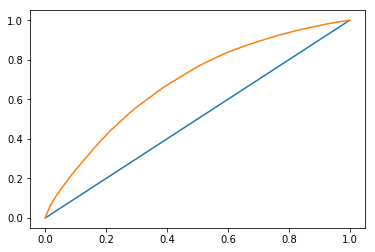

In [185]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.plot(fpr, tpr)

In [187]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, prob_1)

0.6827321655256338

Not bad, considering we have not performed any feature engineering at all!

In [190]:
result.bestModel.save('chosen_model')

### Further Reading

https://spark.apache.org/docs/2.3.0/ml-tuning.html

https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark

In [ ]:
from __future__ import print_function
from pyspark.sql import types, functions, SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('gs://kschool-edition12/inputdata/*.gz', header=True, inferSchema=True)
df2 = df.select('FlightDate', 'DayOfWeek', 'Year', 'Month', 'DayofMonth', 'DayOfWeek',
                 df['Reporting_Airline'].alias('Carrier'), 
                 df['Tail_Number'].alias('TailNum'), 
                 df['Flight_Number_Reporting_Airline'].alias('FlightNum'), 
                 'Origin', 'OriginCityName', 'OriginStateName', 
                 'Dest', 'DestCityName', 'DestStateName',
                 'DepTime', 'DepDelay', 'AirTime', 'Distance')

df3 = df2.na.drop()
flights = df3.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))
delays = flights.withColumn('Delayed', (flights['DepDelay'] > 15).cast(types.IntegerType()))

categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in 
                 delays.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'Hour']

target_field = 'Delayed'

string_indexers = [StringIndexer(inputCol=field, outputCol=field+'Index', handleInvalid='keep') 
                       for field in string_fields]

encoders_cat = [OneHotEncoder(inputCol=field, 
                              outputCol=field+'OneHot') 
                for field in categorical_fields if field not in string_fields]

encoders_str = [OneHotEncoder(inputCol=field+'Index', 
                              outputCol=field+'OneHot') 
                for field in string_fields]

cols_to_concatenate = [ field + 'OneHot' for field in categorical_fields] + continuous_fields
assembler = VectorAssembler(inputCols=cols_to_concatenate, outputCol='features')

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='Delayed')

pipeline =Pipeline(stages=string_indexers + 
                          encoders_str + 
                          encoders_cat + 
                          [assembler] + 
                          [rf])


evaluator = BinaryClassificationEvaluator(labelCol='Delayed')

builder = ParamGridBuilder()

params = builder.addGrid(rf.maxDepth, [5, 15])\
                .addGrid(rf.numTrees, [5, 30])\
                .build()

validator = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=params,
                           evaluator=evaluator)

result = validator.fit(delays)

result.transform(delays).write.json('gs://kschool-edition12/predictions_out')
result.bestModel.save('gs://kschool-edition12/chosen_model')
spark.stop()